Lastname:     Patel<br>
Date:         February 27th, 2020<br>
Approach:     Used random forest algorithm with 30+ random decision trees  <br> 
Expected AUC: 0.83 - 0.85 AUC<br>

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_roc_curve

### Training Data

In [90]:
df = pd.read_csv('data/train.csv')
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.head(5)

There are 10000 rows and 10 columns


,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [109]:
df

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,None,1,4,0
1,50,0.004733,desktop,F,0,64328,None,3,2,0
2,54,0.004129,laptop,M,0,83439,None,3,7,0
3,16,0.005117,Android,F,0,30110,None,3,0,0
4,37,0.003635,desktop,M,0,76565,None,1,5,0
...,...,...,...,...,...,...,...,...,...,...
9995,41,0.004225,desktop,M,0,64489,None,3,8,0
9996,50,0.004751,other,F,0,88643,None,3,0,0
9997,60,0.003804,other,M,0,87870,None,2,9,0
9998,18,0.003838,laptop,M,0,56468,None,2,0,0


In [153]:
df[:1]

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,None,1,4,0


In [119]:
replaced = df['age'].replace(np.nan, 0)
replaced

0       56
1       50
2       54
3       16
4       37
        ..
9995    41
9996    50
9997    60
9998    18
9999    33
Name: age, Length: 10000, dtype: int64

### Testing Data

In [3]:
test_data = pd.read_csv('data/test.csv')
nRow, nCol = test_data.shape
print(f'There are {nRow} rows and {nCol} columns')
test_data.head(5)

There are 10000 rows and 9 columns


,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure
0,34,0.005134,Android,F,1,40376,1,3,7
1,53,0.005223,desktop,F,1,84511,1,1,11
2,46,0.004939,laptop,F,0,79322,1,1,4
3,36,0.004924,Android,F,0,63295,1,2,0
4,28,0.005146,other,F,1,36170,1,3,3


### Preprocessing
#### Replacing NaN

In [4]:
permutation_train = np.random.permutation(train_data['gender'])
end = len(permutation_train)
train_data['gender'] = train_data['gender'].apply(lambda x: permutation_train[np.random.randint(end)] if pd.isnull(x) else x)
train_data['gender'].replace(np.NaN, 'F', inplace=True)

permutation_test = np.random.permutation(test_data['gender'])
end = len(permutation_test)
test_data['gender'] = test_data['gender'].apply(lambda x: permutation_test[np.random.randint(end)] if pd.isnull(x) else x)
test_data['gender'].replace(np.NaN, 'F', inplace=True)

#### Onehot encoding

In [5]:
train_data = pd.concat([train_data, pd.get_dummies(train_data['gender'], prefix='gender')], axis=1)
train_data.drop(['gender'], axis=1, inplace=True)

test_data = pd.concat([test_data, pd.get_dummies(test_data['gender'], prefix='gender')], axis=1)
test_data.drop(['gender'], axis=1, inplace=True)

#### Label encoding

In [6]:
labelencoder = LabelEncoder()

train_data['device_type'] = labelencoder.fit_transform(train_data['device_type'])
test_data['device_type'] = labelencoder.fit_transform(test_data['device_type'])

In [7]:
outcome = train_data.outcome
train_data = train_data.drop('outcome', axis=1)
train_data = train_data.join(outcome)

#### Standardizing 

In [8]:
train_data['income'] = StandardScaler().fit_transform(train_data['income'].values.reshape(-1, 1))
train_data['cost_of_ad'] = StandardScaler().fit_transform(train_data['cost_of_ad'].values.reshape(-1, 1))
train_data['age'] = StandardScaler().fit_transform(train_data['age'].values.reshape(-1, 1))

test_data['income'] = StandardScaler().fit_transform(test_data['income'].values.reshape(-1, 1))
test_data['cost_of_ad'] = StandardScaler().fit_transform(test_data['cost_of_ad'].values.reshape(-1, 1))
test_data['age'] = StandardScaler().fit_transform(test_data['age'].values.reshape(-1, 1))

#### Shuffling rows

In [9]:
train_data = train_data.sample(frac=1).reset_index(drop=True)

#### train_data and train_labels

In [10]:
X = train_data.iloc[:,:10]  
y = train_data.iloc[:, 10]

#### Training data and Tesing Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

#### Helper function for performance check

In [12]:
def performance_check(classifier, X_train, y_train, X_test, y_test, y_pred):
    print("Accuracy on training set: {:.3f}".format(classifier.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(classifier.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    logit_roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest(area = %0.2f)'%logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()   

#### Random Forest Classifier

Accuracy on training set: 0.932
Accuracy on test set: 0.905
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1801
           1       0.61      0.14      0.22       199

    accuracy                           0.91      2000
   macro avg       0.76      0.56      0.59      2000
weighted avg       0.88      0.91      0.88      2000

[[1784   17]
 [ 172   27]]


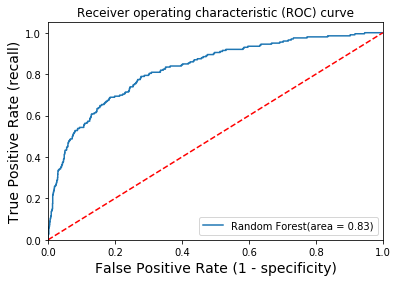

In [13]:
random_forest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=34,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_pred = random_forest.fit(X_train, y_train).predict(X_test)
performance_check(random_forest, X_train, y_train, X_test, y_test, rf_pred)

### Evaluating on original test data

In [16]:
test_data_labels = pd.Series(random_forest.predict(test_data))
test_data_labels.head() # first 5/10000 (test.csv)

0    0
1    0
2    0
3    0
4    0
dtype: int64